In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

In [2]:
import vqe_functions as vqe

## VQE

In [7]:
N = 4
J = 1
l_steps = 100
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.03
epochs = 250
shift_invariance = 0

In [8]:
dev_vqe_default = qml.device('default.qubit', wires = N, shots = None)
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [9]:
@qml.qnode(dev_vqe_default)
def vqe_cost_fn_default(vqe_params, N, shift_invariance, H):
    vqe.circuit(N, vqe_params, shift_invariance)
        
    # return <psi|H|psi>
    return qml.expval(H)

@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)


#### VQE learning functions:

* ***vqe.train()***: (first) standard learning function:
    * <span style="color: green;">Parameters recycling (final learnt gates are the initial parameters of next datapoint/state)</span>
    * <span style="color: red;">Single core (No Multiprocessing)</span>
* ***vqe.mp_train()***: Multiprocessed version of standard learning function:
    * <span style="color: green;">Multi core</span>
    * <span style="color: green;">Pre-training with parameters recycling</span>
    * <span style="color: green;">Automatically removing from training states with a relative error below a CUTOFF</span>
    * <span style="color: red;">No parameter recycling during training (less smooth results)</span>
* ***vqe.mp_train_SPSA()***: Multiprocessed version of standard learning function:
    * <span style="color: green;">Multi core</span>
    * <span style="color: green;">Pre-training with parameters recycling</span>
    * <span style="color: green;">SPSA optimizer</span>
    * <span style="color: red;">No parameter recycling during training (less smooth results)</span>
    * <span style="color: red;">No progress-bar</span>

### VQE on noiseless Circuit

***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
n_epochs     = 250 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

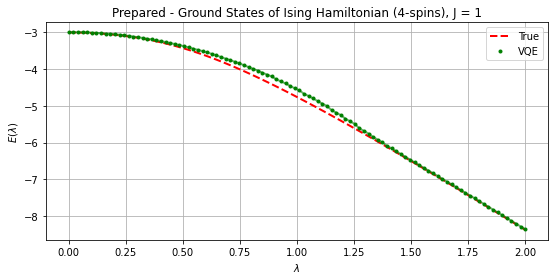

  0%|          | 0/250 [00:00<?, ?it/s]

['./vqe_states_job/vqe_params_0noise.job']

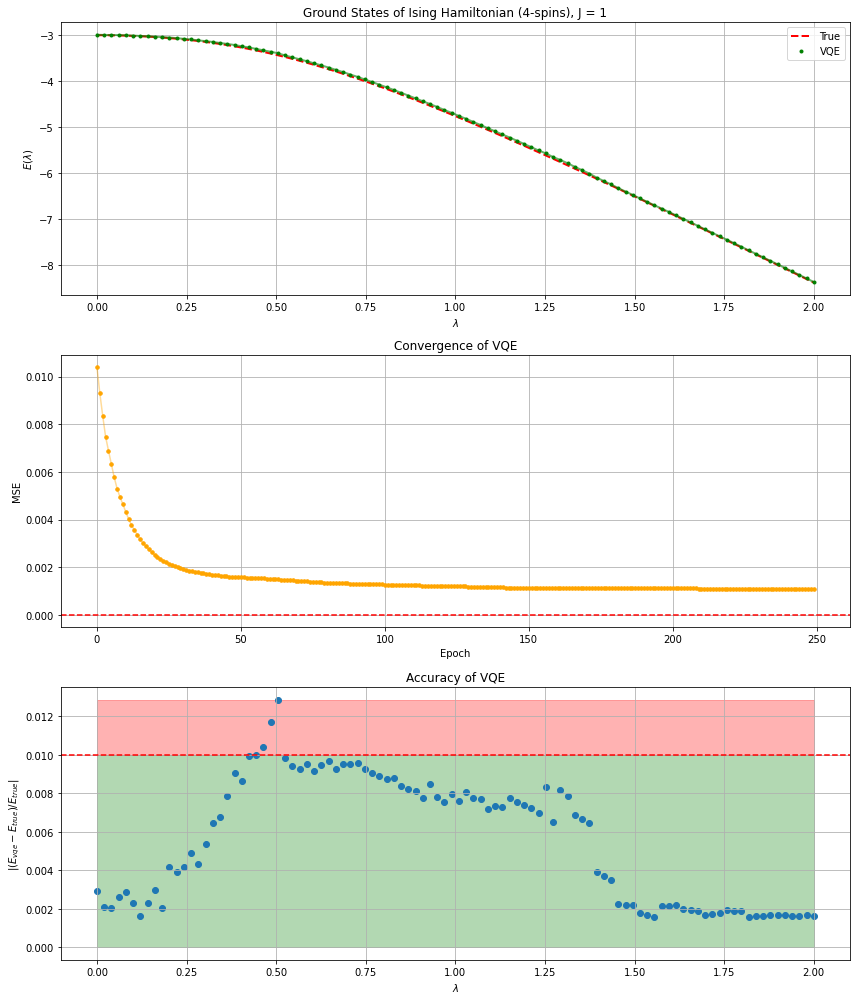

In [10]:
vqe_e, errs, thetas, ys = vqe.mp_train(step_size, lams, epochs, N, J, vqe_cost_fn_mixed, 
                                             shift_invariance = shift_invariance, p_noise = 0, p_noise_ent = 0,
                                             circuit = True, plots = True, prepare_states = True, preplots = True,
                                             prep_step_size = 0.05)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_states_job/vqe_params_0noise.job')


### VQE on noisy Circuit

In [6]:
N = 4
J = 1
l_steps = 100
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.05
random_shift = 0.4
epochs = 5000

***Parameters:***

step_size    = 0.05 (Step size of the optimizer)
random_shift = 0.4 (Random shift of parameters of the optimizer)
n_epochs     = 5000 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

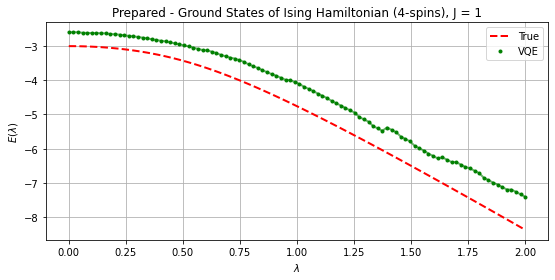

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


['./vqe_states_job/vqe_params_0.005noise.job']

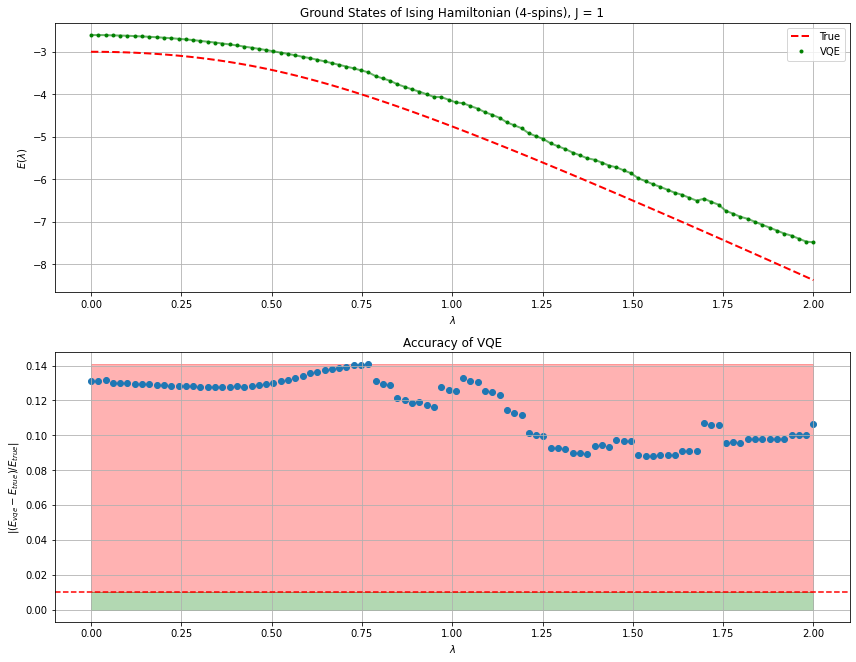

In [7]:
vqe_e, errs, thetas, ys = vqe.mp_train_SPSA(step_size, random_shift, lams, epochs, N, J, vqe_cost_fn_mixed, 
                                             shift_invariance = shift_invariance, p_noise = 0.005, p_noise_ent = 0.005,
                                             circuit = True, plots = True, prepare_states = True, preplots = True,
                                             prep_step_size = 0.3)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_states_job/vqe_params_0.005noise.job')


In [11]:
print('MSE:', errs)

MSE: 0.007998738687313092
